In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

In [29]:
path = untar_data(URLs.MNIST_SAMPLE)


In [32]:
Path.BASE_PATH = path

In [33]:
path

Path('.')

In [4]:
sevens = (path/'train/7').ls()
threes = (path/'train/3').ls()
sevens_stack = torch.stack([tensor(Image.open(o)) for o in sevens]).float() / 255
threes_stack = torch.stack([tensor(Image.open(o)) for o in threes]).float() / 255


In [5]:
mean7 = sevens_stack.mean(0)
mean3 = threes_stack.mean(0)


In [6]:
def minst_dist(a, b): return (a - b).abs().mean()

In [7]:
def is_3(o): return minst_dist(o, mean3) < minst_dist(o, mean7)

In [8]:
is_3(sevens_stack[3])

tensor(False)

In [9]:
valid_sevens_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls()]).float() / 255
valid_threes_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls()]).float() / 255


In [10]:
(sum(1 - is_3(o).float() for o in valid_sevens_stack) / len(valid_sevens_stack),
sum(is_3(o).float() for o in valid_threes_stack) / len(valid_threes_stack))


(tensor(0.9854), tensor(0.9168))

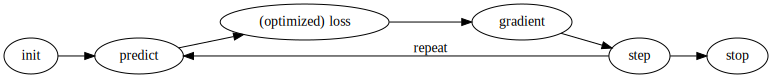

In [63]:
gv('''
init->predict -> "(optimized) loss" ->gradient->step->stop
step->predict[label=repeat]
''')

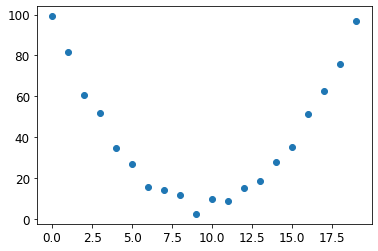

In [12]:
# Rollercoaster
time = torch.arange(20).float()

speed = 9*torch.rand(20).float() + (time-9.5)**2 + 1

plt.scatter(time, speed)

In [13]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-100,300)

In [14]:

def f(x, params):
    a, b, c = params
    return a * x**2 + b * x + c

loss tensor(1536.5359, grad_fn=<MeanBackward0>)
loss tensor(1335.2625, grad_fn=<MeanBackward0>)
loss tensor(1297.1687, grad_fn=<MeanBackward0>)
loss tensor(1289.9537, grad_fn=<MeanBackward0>)
loss tensor(1288.5818, grad_fn=<MeanBackward0>)
loss tensor(1288.3157, grad_fn=<MeanBackward0>)
loss tensor(1288.2589, grad_fn=<MeanBackward0>)
loss tensor(1288.2415, grad_fn=<MeanBackward0>)
loss tensor(1288.2317, grad_fn=<MeanBackward0>)
loss tensor(1288.2234, grad_fn=<MeanBackward0>)
loss tensor(1288.2155, grad_fn=<MeanBackward0>)
loss tensor(1288.2074, grad_fn=<MeanBackward0>)
loss tensor(1288.1992, grad_fn=<MeanBackward0>)
loss tensor(1288.1912, grad_fn=<MeanBackward0>)
loss tensor(1288.1833, grad_fn=<MeanBackward0>)
loss tensor(1288.1750, grad_fn=<MeanBackward0>)
loss tensor(1288.1672, grad_fn=<MeanBackward0>)
loss tensor(1288.1592, grad_fn=<MeanBackward0>)
loss tensor(1288.1511, grad_fn=<MeanBackward0>)
loss tensor(1288.1431, grad_fn=<MeanBackward0>)
loss tensor(1288.1350, grad_fn=<MeanBack

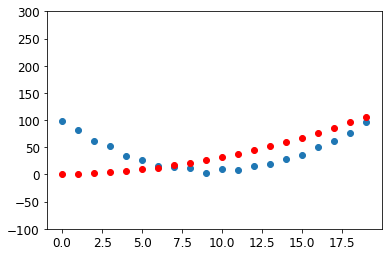

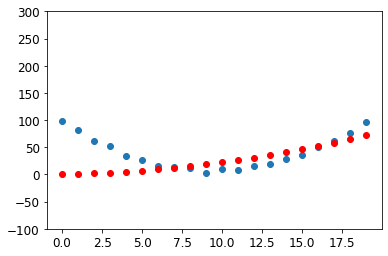

In [15]:

weights = torch.rand(3).float().requires_grad_()


def mse(preds, targets):
    return ((targets - preds)**2).mean()

lr = 1e-5
def epoch(weights):
    #print('weights', weights)
    preds = f(time, weights)
    loss = mse(preds, speed)
    print('loss', loss)
    loss.backward()
    weights.data -= weights.grad.data * lr
    weights.grad = None
    return weights

preds = f(time, weights)
show_preds(preds)
for _ in range(40):
    weights = epoch(weights)
preds = f(time, weights)
show_preds(preds)

In [16]:
t = torch.empty(5, 6, 7)
t.size(), t.ndim, t.shape, len(t)

(torch.Size([5, 6, 7]), 3, torch.Size([5, 6, 7]), 5)

In [17]:

#1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

(torch.tensor([[i*3+j+1 for j in range(3)] for i in range(3)]) * 2)[-2:,-2:]

tensor([[10, 12],
        [16, 18]])

## MNIST loss func

In [132]:
train_x = torch.cat([threes_stack, sevens_stack]).view(-1, 28*28)
train_y = tensor([0] * len(threes_stack) + [1] * len(sevens_stack)).unsqueeze(1)
dset = list(zip(train_x, train_y))
train_x.shape, train_y.shape, train_x[0].shape

(torch.Size([12396, 784]), torch.Size([12396, 1]), torch.Size([784]))

In [133]:
valid_x = torch.cat([valid_threes_stack, valid_sevens_stack]).view(-1, 28*28)
valid_y = tensor([0] * len(valid_threes_stack) + [1] * len(valid_sevens_stack)).unsqueeze(1)
vdset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape


(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [134]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

In [135]:
weights = init_params((28*28, 1))
bias = init_params(1)
bias, weights.T.shape

(tensor([-0.1604], requires_grad=True), torch.Size([1, 784]))

In [136]:
def linear1(xb): return xb@weights + bias

In [137]:
preds = linear1(train_x)
accuracy = (preds > 0.0).float() == train_y
accuracy, accuracy.float().mean().item()

(tensor([[ True],
         [ True],
         [ True],
         ...,
         [False],
         [ True],
         [ True]]),
 0.7829945087432861)

In [138]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()


In [139]:
loss = mnist_loss(preds, train_y)
loss

In [141]:
#loss.backward()
weights.grad.shape

torch.Size([784, 1])

In [144]:
weights.data[10] *= 1.1
preds = linear1(train_x)
loss, mnist_loss(preds, train_y)

(tensor(0.2242, grad_fn=<MeanBackward0>),
 tensor(0.2242, grad_fn=<MeanBackward0>))